In [1]:
import tensorflow as tf
# import 
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from patchify import patchify, unpatchify
import cv2
from tensorflow.keras.models import load_model
from skimage.color import gray2rgb

In [2]:
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred) 
    tp = tf.reduce_sum(y_true * y_pred)  
    fp = tf.reduce_sum(y_pred * (1 - y_true))  
    fn = tf.reduce_sum((1 - y_pred) * y_true)  

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())


In [3]:
# Load the model you trained in task5_training.ipynb
model = load_model("/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Retake/Model/1_celine_231265_unet_model_2_256px.h5", custom_objects={'f1': f1})

2025-10-14 23:57:27.200900: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-10-14 23:57:27.200933: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-14 23:57:27.200938: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-14 23:57:27.200960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-14 23:57:27.200975: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TypeError: string indices must be integers

In [ ]:
def padder(image, patch_size):
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

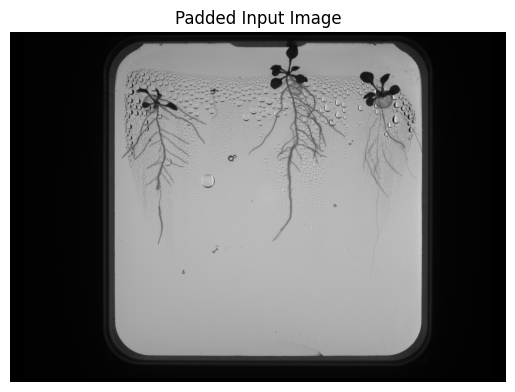

Padded Image Shape: (3072, 4352, 3)


In [ ]:
# Load and pad the test image
image_path = 'task5_test_image.png'
image = cv2.imread(image_path)
patch_size = 256
image = padder(image, patch_size)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Padded Input Image')
plt.show()

print("Padded Image Shape:", image.shape)


In [ ]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    gray = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                 cv2.THRESH_BINARY_INV, 11, 2)
    gray = cv2.equalizeHist(gray)
    return gray, image

def detect_edges(gray):
    edges = cv2.Canny(gray, 50, 150) 
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))  
    return edges

def find_largest_bounding_box(edges, image_shape, min_size_ratio=0.3):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    best_bbox = None
    min_width, min_height = min_size_ratio * image_shape[1], min_size_ratio * image_shape[0]

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        if area > max_area and w >= min_width and h >= min_height:
            max_area = area
            best_bbox = (x, y, w, h)
    
    return best_bbox

def check_bbox_tolerance(bbox, expected_bbox, tolerance=0):
    if expected_bbox is None:
        return True  
    
    x, y, w, h = bbox
    ex, ey, ew, eh = expected_bbox
    
    # Check if the detected bounding box is within the tolerance of the expected bbox edges
    if (abs(x - ex) <= tolerance and abs(y - ey) <= tolerance and 
        abs(w - ew) <= tolerance and abs(h - eh) <= tolerance):
        return True
    return False

def crop_to_square(image, bbox, padding=5, tolerance=0):
    x, y, w, h = bbox
    size = max(w, h)  
    
    # Center crop around the bounding box
    cx, cy = x + w // 2, y + h // 2
    x1 = max(0, cx - size // 2)
    y1 = max(0, cy - size // 2)
    x2 = min(image.shape[1], x1 + size)
    y2 = min(image.shape[0], y1 + size)

    # Enforce ± tolerance for cropping
    if x1 - tolerance > 0:
        x1 -= tolerance
    if y1 - tolerance > 0:
        y1 -= tolerance
    if x2 + tolerance < image.shape[1]:
        x2 += tolerance
    if y2 + tolerance < image.shape[0]:
        y2 += tolerance

    # Crop the image
    return image[y1:y2, x1:x2]

def process_and_display(image, title, expected_bbox=None):
    gray, original = preprocess_image(image)
    edges = detect_edges(gray)
    bbox = find_largest_bounding_box(edges, gray.shape, min_size_ratio=0.2)  
    
    # Debug visualization
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Edges Detected")
    plt.imshow(edges, cmap='gray')
    plt.axis("off")
    
    # Check if the detected bounding box is within tolerance of the expected bbox
    if bbox and check_bbox_tolerance(bbox, expected_bbox):
        cropped = crop_to_square(original, bbox, padding=80, tolerance=0)  
        plt.subplot(1, 2, 2)
        plt.title(f"Cropped Petri Dish: {title}")
        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()
    else:
        print(f"Bounding box for {title} is not within the tolerance range.")
        plt.subplot(1, 2, 2)
        plt.title(f"Original Image: {title}")
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()


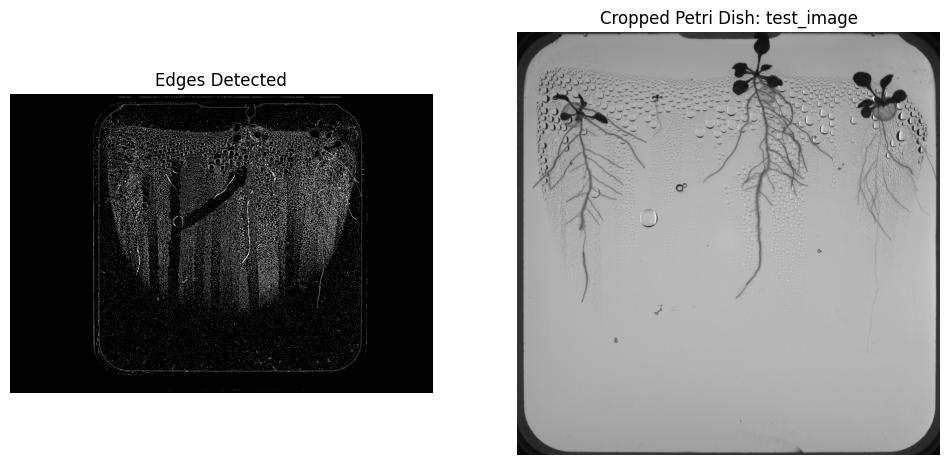

In [ ]:
process_and_display(image, "test_image")

In [ ]:
def process_and_crop(image, title, expected_bbox=None):
    gray, original = preprocess_image(image)
    edges = detect_edges(gray)
    bbox = find_largest_bounding_box(edges, gray.shape, min_size_ratio=0.2)  
    
    # Debug visualization
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Edges Detected")
    plt.imshow(edges, cmap='gray')
    plt.axis("off")
    
    # Check if the detected bounding box is within tolerance
    if bbox and check_bbox_tolerance(bbox, expected_bbox):
        cropped = crop_to_square(original, bbox, padding=80, tolerance=0)  
        plt.subplot(1, 2, 2)
        plt.title(f"Cropped Petri Dish: {title}")
        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()
        return cropped  # Return the cropped Petri dish
    else:
        print(f"Bounding box for {title} is not within the tolerance range.")
        plt.subplot(1, 2, 2)
        plt.title(f"Original Image: {title}")
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()
        return None

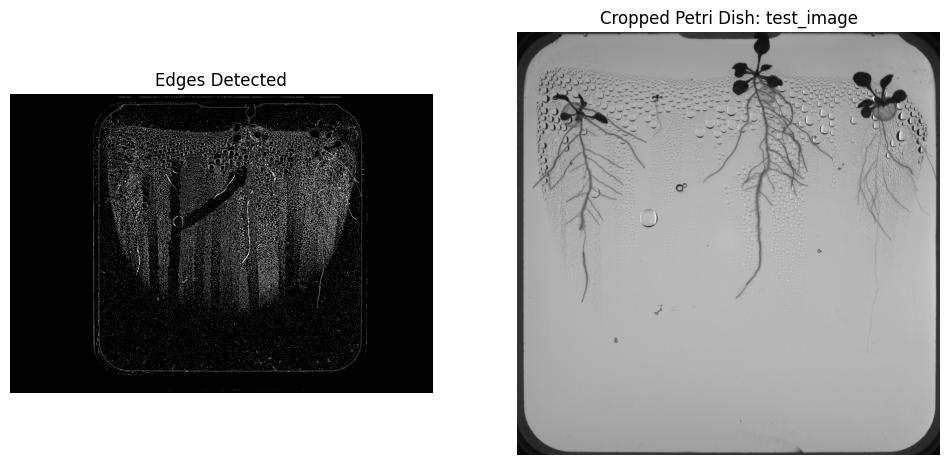

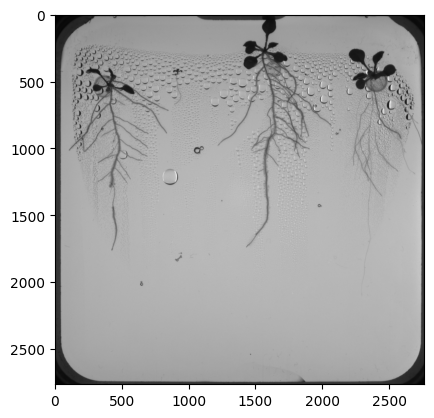

In [ ]:
cropped_petri_dish = process_and_crop(image, "test_image")
petri_dish = cropped_petri_dish
plt.imshow(petri_dish)
    
 

In [ ]:
petri_dish.shape


(2764, 2764, 3)

In [ ]:
# Get the dimensions of the cropped Petri dish
height, width, _ = petri_dish.shape

# Calculate padding to make dimensions divisible by 256
pad_height = (256 - height % 256) if height % 256 != 0 else 0
pad_width = (256 - width % 256) if width % 256 != 0 else 0

# Apply padding
padded_petri_dish = cv2.copyMakeBorder(
    petri_dish,
    0, pad_height, 0, pad_width,
    cv2.BORDER_CONSTANT,
    value=0  # Black padding
)

# Convert to grayscale
petri_dish_padded= cv2.cvtColor(padded_petri_dish, cv2.COLOR_BGR2GRAY)

print("Padded Shape:", petri_dish_padded.shape)

Padded Shape: (2816, 2816)


In [ ]:
# Pad the petri dish
petri_dish_padded.shape

(2816, 2816)

2025-03-28 16:50:33.545103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


Text(0.5, 1.0, 'Prediction')

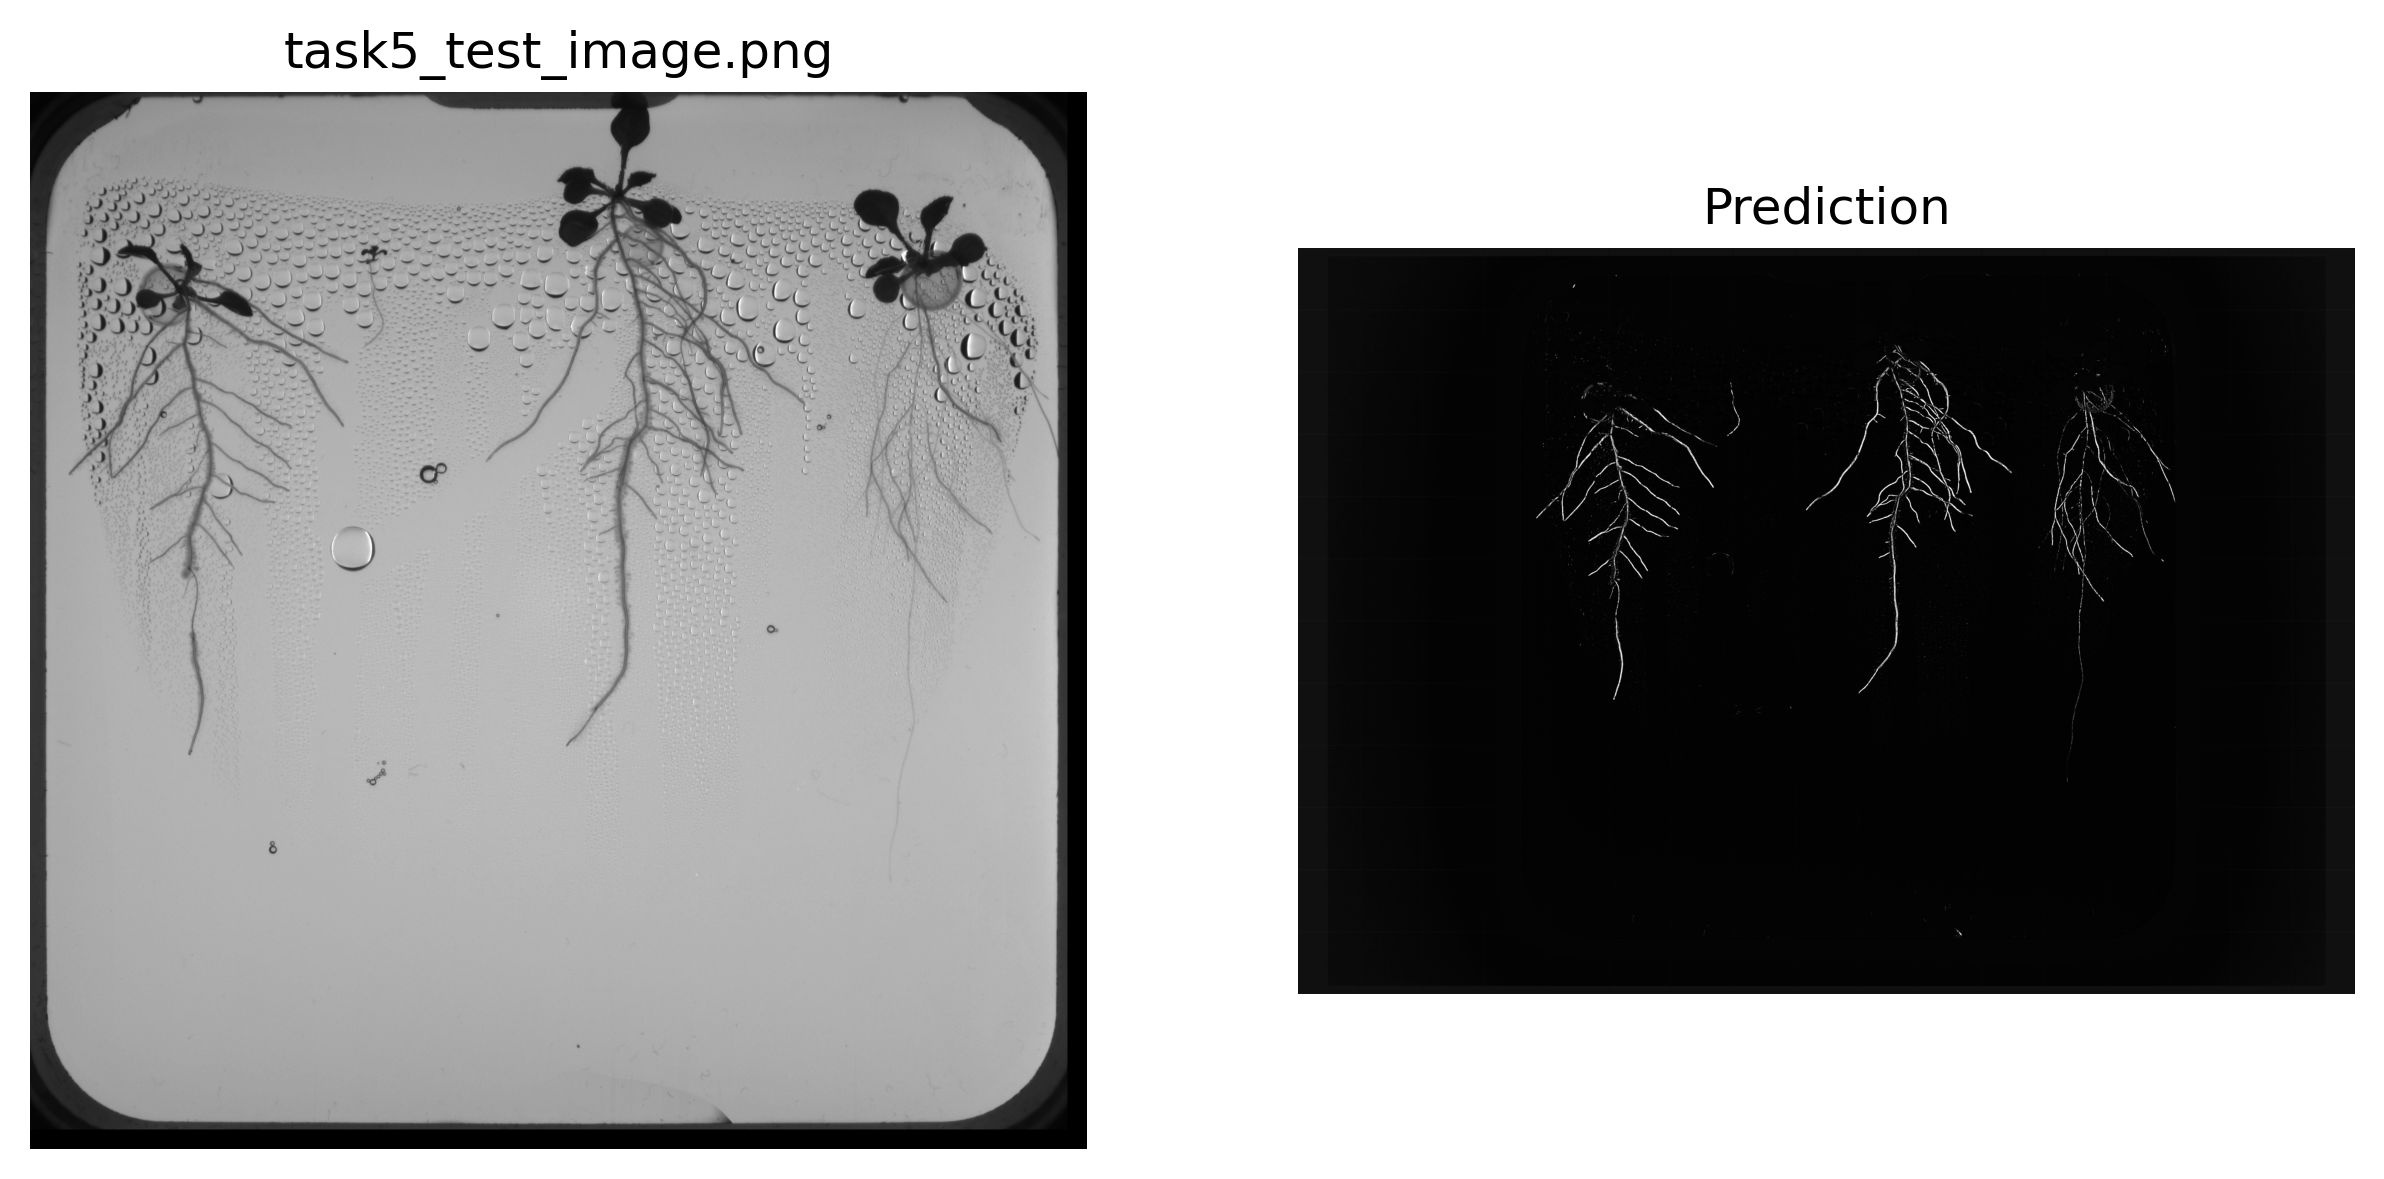

In [ ]:
# PATCH
patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)
i = patches.shape[0]
j = patches.shape[1]
patches = patches.reshape(-1, patch_size, patch_size, 3)
# PREDICT
preds = model.predict(patches/255)
preds = preds.reshape(i, j, 256, 256)
predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
# Convert mask to RGB
predicted_mask_rgb = gray2rgb((predicted_mask > 0.5).astype(np.uint8) * 255)  

# Create an overlay by blending the mask with the original image
overlay = image.copy()
overlay[predicted_mask > 0.5] = [255, 0, 0]  
alpha = 0.5  # Transparency factor
blended = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
# UNPATCH

f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
ax[0].imshow(petri_dish_padded, cmap='gray')
ax[0].axis('off')
ax[0].set_title('task5_test_image.png')
ax[1].imshow(predicted_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Prediction')

In [ ]:
predicted_mask.shape, image.shape

((3072, 4352), (3072, 4352, 3))

As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

In [ ]:
# Apply the corrections
def unpad_image(padded_image, original_shape):
    
    orig_height, orig_width = original_shape
    return padded_image[:orig_height, :orig_width]

# Original petri dish size before padding
original_petri_dish_shape = (3072, 4352)  # Replace with your actual original cropped petri dish shape

# Remove padding from the predicted mask
predicted_mask_corrected = unpad_image(predicted_mask, original_petri_dish_shape)

print("Corrected Mask Shape:", predicted_mask_corrected.shape)
predicted_mask_corrected.shape

Corrected Mask Shape: (3072, 4352)


(3072, 4352)

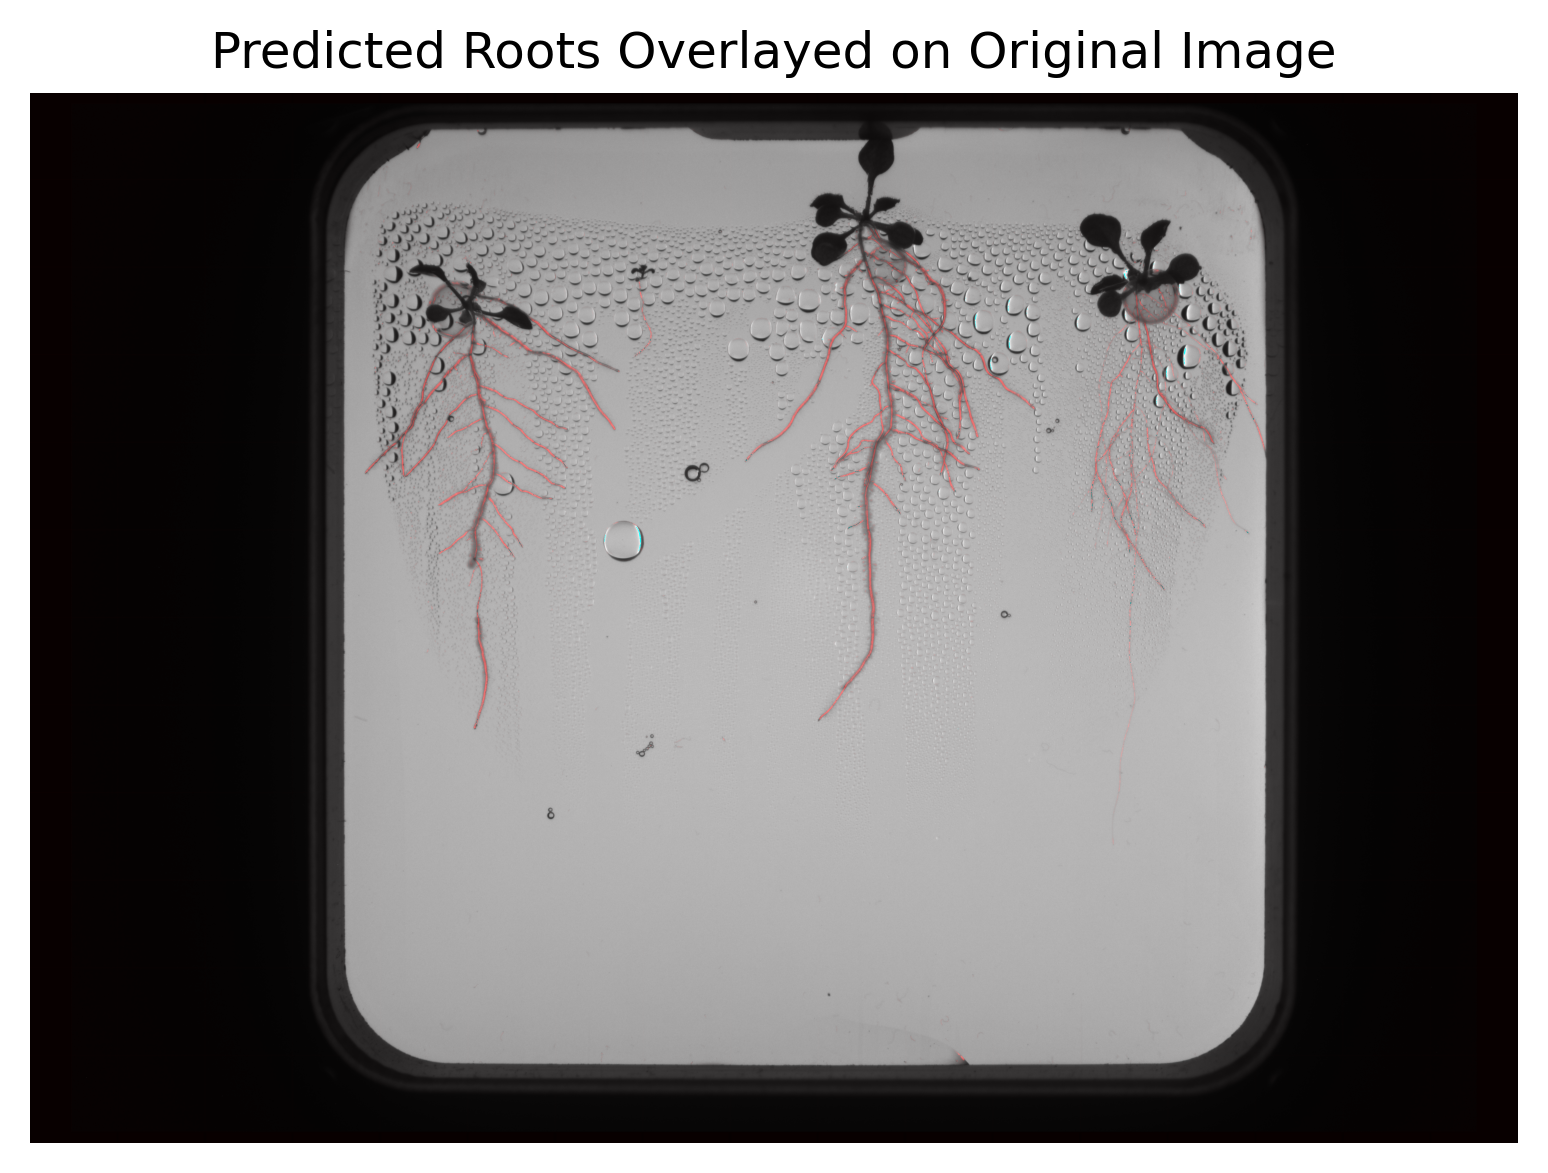

In [ ]:
# Normalize the mask to 0-255 if not already
if predicted_mask.max() <= 1:  # If the mask values are in range [0, 1]
    predicted_mask = (predicted_mask * 255).astype(np.uint8)

# Ensure predicted_mask is converted to RGB for overlay
predicted_mask_rgb = cv2.cvtColor(predicted_mask, cv2.COLOR_GRAY2BGR)

# Apply a strong red color to the mask
colored_mask = np.zeros_like(predicted_mask_rgb)
colored_mask[:, :, 2] = predicted_mask  # Assign to the red channel (strong red)

# Blend the original image and the colored mask (adjust alpha for transparency)
alpha = 0.5  # Transparency factor
overlay_image = cv2.addWeighted(image.astype(np.float32), 1, colored_mask.astype(np.float32), alpha, 0)

# Convert back to uint8 for visualization
overlay_image = overlay_image.astype(np.uint8)

# Plot the overlay image
plt.figure(dpi=300)
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Predicted Roots Overlayed on Original Image")
plt.show()

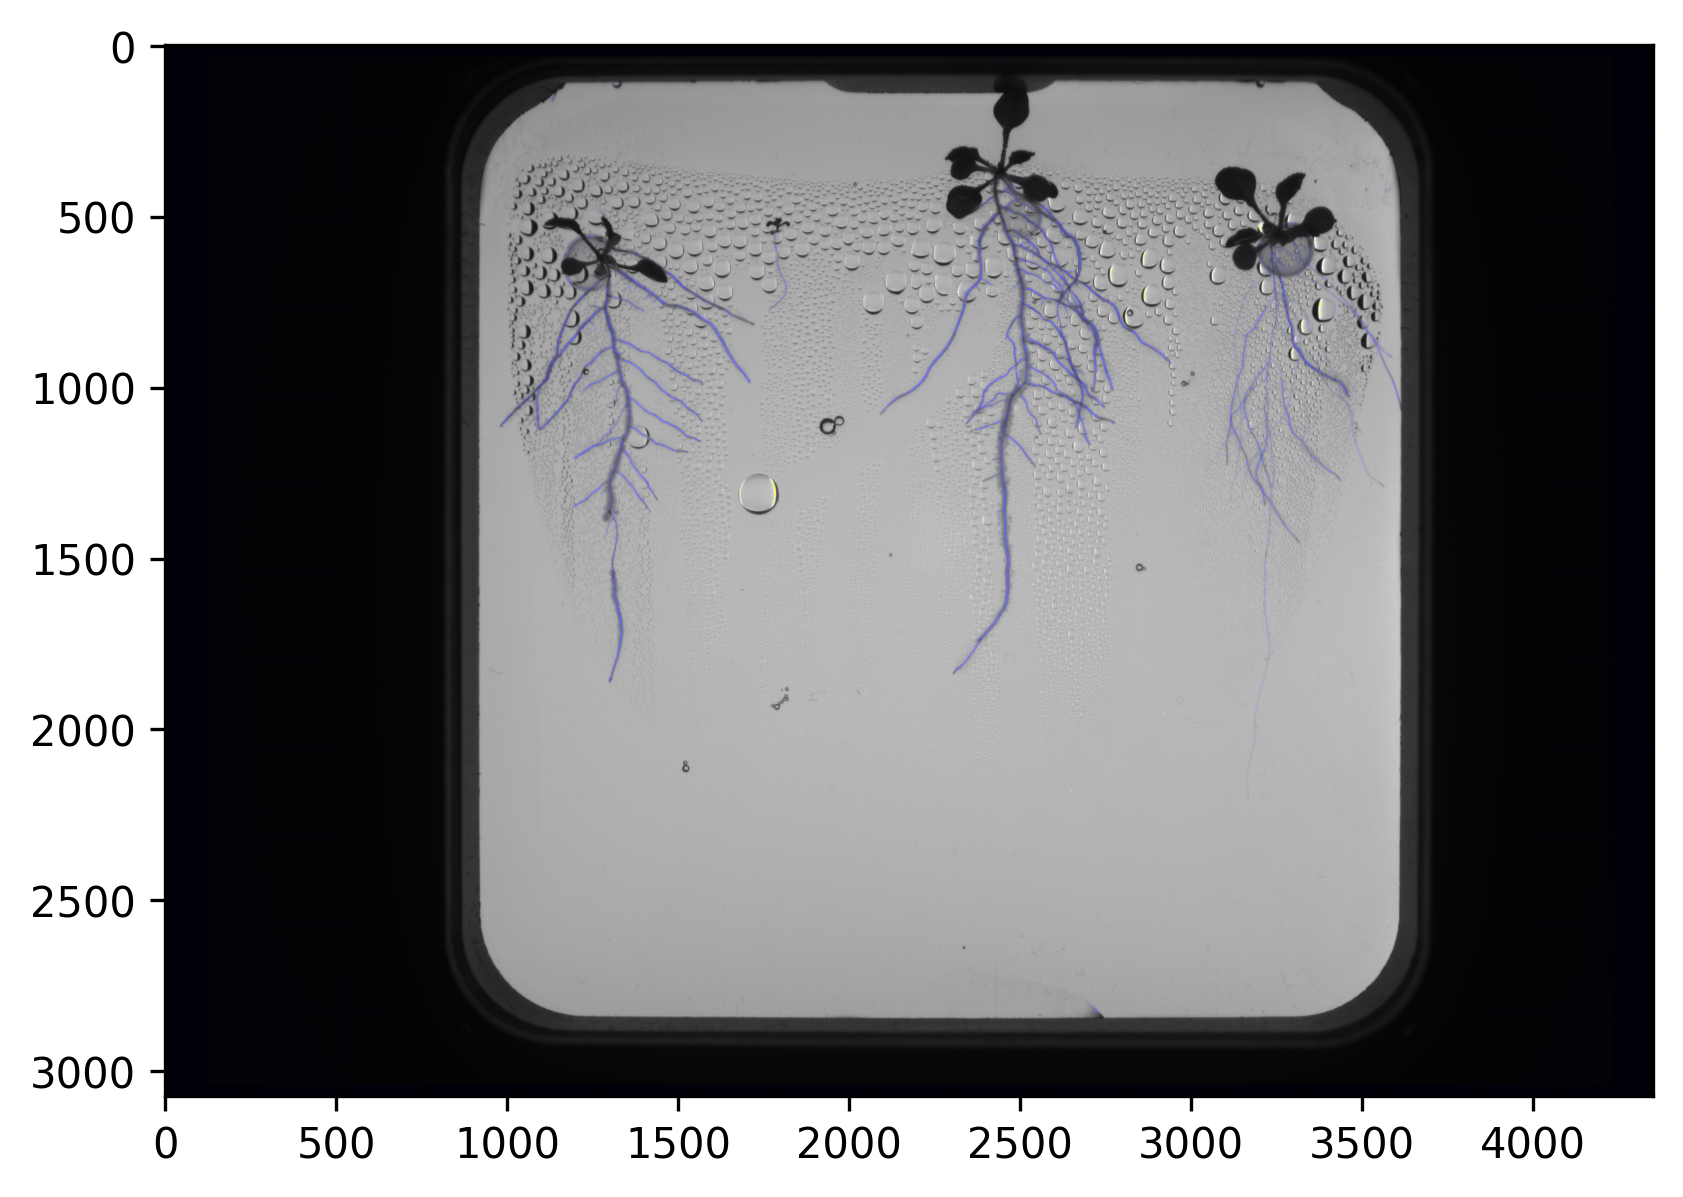

In [ ]:
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: Plot such an image to prove alignment.

plt.figure(dpi=300)
plt.imshow(overlay_image)

In [ ]:
# REQUIREMENT: Save the predicted mask, it is a deliverable.
# REQUIREMENT: Input/Output size must be the same.
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: The predicted mask must be binary.
# REQUIREMENT: Non-root pixels must be 0, root pixels must be 255 (unlike Task 1)
# REQUIREMENT: naming convention task5_test_image_prediction_studentname_studentnumber.png

# Ensure the predicted mask is binary (0 for non-root, 255 for root)
binary_mask = (predicted_mask_corrected > 0.5).astype(np.uint8) * 255

# Validate that input/output sizes match
assert binary_mask.shape == image.shape[:2], "Input and output shapes do not match!"

# Save the predicted mask with the correct naming convention
output_filename = "task5_test_image_prediction_celine_231265.png"  # Replace with your name and number
cv2.imwrite(output_filename, binary_mask)

print(f"Predicted binary mask saved successfully as: {output_filename}")

Predicted binary mask saved successfully as: task5_test_image_prediction_celine_231265.png
